In [1]:
# coding: utf-8

# # SMS Spam detection using Naive Bayes
# 
# Source : talk on "Data Science with Python" at the [University of Economics](https://www.vse.cz/english/) in Prague, December 2014. [@RadimRehurek](https://twitter.com/radimrehurek).
# 
# The goal of this talk is to demonstrate some high level, introductory concepts behind (text) machine learning. The concepts are demonstrated by concrete code examples in this notebook, which you can run yourself (after installing IPython, see below), on your own computer.
# 
# The talk audience is expected to have some basic programming knowledge (though not necessarily Python) and some basic introductory data mining background. This is *not* an "advanced talk" for machine learning experts.
# 
# The code examples build a working, executable prototype: an app to classify phone SMS messages in English (well, the "SMS kind" of English...) as either "spam" or "ham" (=not spam).

# [![](http://radimrehurek.com/data_science_python/python.png)](http://xkcd.com/353/)

# The language used throughout will be [Python](https://www.python.org/), a general purpose language helpful in all parts of the pipeline: I/O, data wrangling and preprocessing, model training and evaluation. While Python is by no means the only choice, it offers a unique combination of flexibility, ease of development and performance, thanks to its mature scientific computing ecosystem. Its vast, open source ecosystem also avoids the lock-in (and associated bitrot) of any single specific framework or library.
# 
# Python (and of most its libraries) is also platform independent, so you can run this notebook on Windows, Linux or OS X without a change.
# 
# One of the Python tools, the IPython notebook = interactive Python rendered as HTML, you're watching right now. We'll go over other practical tools, widely used in the data science industry, below.

# # End-to-end example: automated spam filtering

In [2]:
#get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
#import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

c:\program files\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\program files\python35\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
c:\program files\python35\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning

In [3]:
# ## Step 1: Load data, look around

# let's download the dataset we'll be using in this demo.
# Go to https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection and download the zip file.
# Unzip it under `data` subdirectory. You should see a file called `SMSSpamCollection`, 
# about 0.5MB in size:

# ```bash
# $ ls -l data
# total 1352
# -rw-r--r--@ 1 kofola  staff  477907 Mar 15  2011 SMSSpamCollection
# -rw-r--r--@ 1 kofola  staff    5868 Apr 18  2011 readme
# -rw-r-----@ 1 kofola  staff  203415 Dec  1 15:30 smsspamcollection.zip
# ```

# This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme`
# file for more info):

In [4]:
#messages = [line.rstrip() for line in open('./data/SMSSpamCollection')]
messages = [line.rstrip() for line in open('./SMSSpamCollection')]
#print (messages.length)

In [5]:
# A collection of texts is also sometimes called "corpus". Let's print the first ten messages in this
# SMS corpus:


for message_no, message in enumerate(messages[:10]):
    print (message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 1

In [6]:
# We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values)
# ("tab separated values") file, where the first column is a label saying whether the given message
# is a normal message ("ham") or "spam". The second column is the message itself.
# 
# This corpus will be our labeled training set. Using these ham/spam examples,
# we'll **train a machine learning model to learn to discriminate between ham/spam automatically**.
# Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or
# spam.

# [![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)]
# (http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

# Instead of parsing TSV (or CSV, or Excel...) files by hand, we can use Python's `pandas` library to
# do the work for us:


#messages = pandas.read_csv("./data/SMSSpamCollection", sep='\t', quoting=csv.QUOTE_NONE,
messages = pandas.read_csv("./SMSSpamCollection", sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print (messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

In [7]:
# With `pandas`, we can also view aggregate statistics easily:

print()
print("Aggregate statistics of messages :")
print()
print(messages.groupby('label').describe())
print()


Aggregate statistics of messages :

      message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4



In [8]:
# How long are the messages?

print("Length of initial few messages :")
print()
messages['length'] = messages['message'].map(lambda text: len(text))
print (messages.head())
print()

Length of initial few messages :

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61



In [9]:
messages.length.plot(bins=20, kind='hist')


print("Aggregate info about LENGTH of messages :")
print()
print(messages.length.describe())
print()

Aggregate info about LENGTH of messages :

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64



In [10]:
# What is that super long message?

print("Print a message longer than 900 characters long :")
print()
print (list(messages.message[messages.length > 900]))
print()

Print a message longer than 900 characters long :

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]



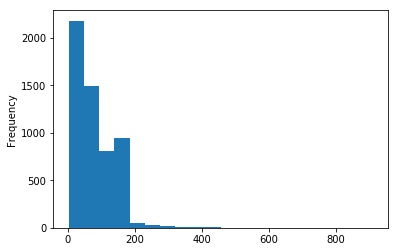

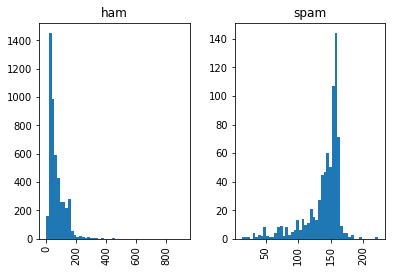

In [11]:
# Is there any difference in message length between spam and ham?


plt.show(messages.hist(column='length', by='label', bins=50).all())

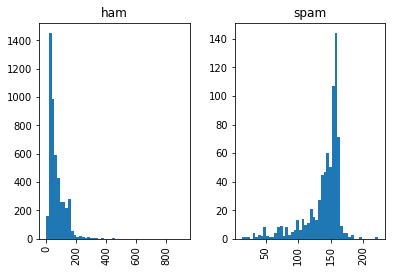

In [12]:
# Is there any difference in message length between spam and ham?


plt.show(messages.hist(column='length', by='label', bins=50).any())

In [13]:
# Good fun, but how do we make computer understand the plain text messages themselves?
# Or can it under such malformed gibberish at all?

# ## Step 2: Data preprocessing

# In this section we'll massage the raw messages (sequence of characters) into vectors
# (sequences of numbers).
# 
# The mapping is not 1-to-1; we'll use the [bag-of-words]
# (http://en.wikipedia.org/wiki/Bag-of-words_model) approach, 
# where each unique word in a text will be represented by one number.
# 
# As a first step, let's write a function that will split a message into its individual words:


def split_into_tokens(message):
#    message = str(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

In [14]:
# Here are some of the original texts again:
#     

print("Initial few messages again :")
print()
print(messages.message.head())
print()

Initial few messages again :

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object



In [15]:
# ...and here are the same messages, tokenized:

print("Tokenized messages :")
print()
print(messages.message.head().apply(split_into_tokens))
print()

Tokenized messages :

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object



In [16]:
# NLP questions:
# 
# 1. Do capital letters carry information?
# 2. Does distinguishing inflected form ("goes" vs. "go") carry information?
# 3. Do interjections, determiners carry information?
# 
# In other words, we want to better "normalize" the text.
# 
# With textblob, we'd detect
#[part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html)
#tags with:

print("Word, Part of Speech POS tag for sentence 'Hello world, how is it going?' :")
print()
print(TextBlob("Hello world, how is it going?").tags)  # list of (word, POS) pairs
print()

Word, Part of Speech POS tag for sentence 'Hello world, how is it going?' :

[('Hello', 'NNP'), ('world', 'NN'), ('how', 'WRB'), ('is', 'VBZ'), ('it', 'PRP'), ('going', 'VBG')]



In [17]:
# and normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation))
# with:


def split_into_lemmas(message):
#    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma
    return [word.lemma for word in words]

In [18]:
# CellStrat
# For example, in English, the verb 'to walk' may appear as 'walk', 'walked', 'walks', 'walking'.
# The base form, 'walk', that one might look up in a dictionary, is called the lemma for the word.
print("After lemmatization, the messages are :")
print()
print(messages.message.head().apply(split_into_lemmas))
print()

After lemmatization, the messages are :

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object



In [19]:
# Better. You can probably think of many more ways to improve the preprocessing:
# decoding HTML entities (those `&amp;` and `&lt;` we saw above);
# filtering out stop words (pronouns etc); adding more features,
# such as an word-in-all-caps indicator and so on.

# ## Step 3: Data to vectors

# Now we'll convert each message, represented as a list of tokens (lemmas) above,
# into a vector that machine learning models can understand.
# 
# Doing that requires essentially three steps, in the bag-of-words model:
# 
# 1. counting how many times does a word occur in each message (term frequency)
# 2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency) -
#    in order to eliminate common words like "is", "that", "and" etc.
# 3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

# Each vector has as many dimensions as there are unique words in the SMS corpus:

#CellStrat
#CountVectorizer : Counts words and vectorizes
# (Convert a collection of text documents to a matrix of token counts)
#TFIDF : Transform a count matrix to a normalized tf or tf-idf representation.
#Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency.
#(eliminate common words by detecting higher frequency words across documents/messages)

SyntaxError: invalid syntax (<ipython-input-19-295cc9b44dc9>, line 25)

In [ ]:
print ("Data to vectors - Convert the messages to a matrix of token counts")
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print()
#print len(bow_transformer.vocabulary_)

In [ ]:
# Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning.
# It contains a multitude of various methods and options.
# 
# Let's take one text message and get its bag-of-words counts as a vector, putting to use our new
# `bow_transformer`:

print("take one particular text message :")
print()
message4 = messages['message'][3]
print (message4)
print()

In [ ]:
print("After Bag of Words and conversion to vector, above text message :")
print()
bow4 = bow_transformer.transform([message4])
print (bow4)
print()
print("Shape of Bag of Words :")
print()
print (bow4.shape)
print()

In [ ]:
# So there are 11012 unique words after lemmatization

# So, nine unique words in message nr. 4, two of them appear twice, the rest only once.
# Sanity check: what are these words the appear twice?

print("Sanity check: what are these words that appear twice :")
print()
#print (bow_transformer.get_feature_names()[6736])
#print (bow_transformer.get_feature_names()[8013])
print (bow_transformer.get_feature_names()[4191])
print (bow_transformer.get_feature_names()[9282])
print()

In [ ]:
# The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

print ("Using the bag of words transformer, transform all the messages :")
messages_bow = bow_transformer.transform(messages['message'])
print()
print ('sparse matrix shape:', messages_bow.shape)
print ('number of non-zeros:', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))
print()

In [ ]:
#the matrix shape :- has 61 million cells (5574 x 11012)
#of these 81621 are filled up and rest are zero. Hence it is said to be sparse
#
#            Word 1   Word 2   Word 3   Word 4...................Word 11012
# Msg 1        0       1        0         1                        0
# Msg 2        0       0        1         1                        0
# .
# .
# .
# Msg 5574     1       0        0         0                        1

In [ ]:
# And finally, after the counting, the term weighting and normalization can be done with [TF-IDF]
# (http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`:

print("Now perform TFIDF fit and transform")
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print("After TFIDF fit and transformation, above text message :")
print()
print (tfidf4)
print()

In [ ]:
# What is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

print("What is the IDF (inverse document frequency) of the word 'u'? Of word 'university'?:")
print()
print (tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print (tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])
print()

In [ ]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once:

print("Transform the entire bag-of-words corpus into TF-IDF corpus at once :")
messages_tfidf = tfidf_transformer.transform(messages_bow)
print("After TFIDF transformation, print shape :")
print()
print (messages_tfidf.shape)

In [ ]:
print(messages_tfidf)

In [ ]:
# There are a multitude of ways in which data can be proprocessed and vectorized.
# These two steps, also called "feature engineering", are typically the most time consuming and
# "unsexy" parts of building a predictive pipeline, but they are very important and require some
# experience. The trick is to evaluate constantly: analyze model for the errors it makes,
# improve data cleaning & preprocessing, brainstorm for new features, evaluate...

# ## Step 4: Training a model, detecting spam

# With messages represented as vectors, we can finally train our spam/ham classifier.
# This part is pretty straightforward, and there are many libraries that realize the training
# algorithms.

# We'll be using scikit-learn here, choosing the [Naive Bayes]
# (http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with
# MultinomialNB AI reference :
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html


#get_ipython().magic("time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])")
print ("Now perform MultinomialNB fit to get the Spam Detector")
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])
print()

In [ ]:
# Let's try classifying our single random message:

print("Let's use this spam detector to try to classify our single random message :")
print()
print ('predicted:', spam_detector.predict(tfidf4)[0])
print ('expected:', messages.label[3])
print()

In [ ]:
# Hooray! You can try it with your own texts, too.
# 
# A natural question is to ask, how many messages do we classify correctly overall?


all_predictions = spam_detector.predict(messages_tfidf)
print("Print all predictions :")
print()
print (all_predictions)
print()

In [ ]:
print ('accuracy of spam predictions', accuracy_score(messages['label'], all_predictions))
print()
print ('confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print ('(row=expected, col=predicted)')
print()

In [ ]:
plt.matshow(confusion_matrix(messages['label'], all_predictions),
            cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [ ]:
# From this confusion matrix, we can compute precision and recall, or their combination
# (harmonic mean) F1:

print("From this confusion matrix, we can compute precision and recall, or their combination (harmonic mean) F1")
print()
print (classification_report(messages['label'], all_predictions))
print()